# Plot conversion rate in %

In [1]:
# from https://github.com/breichholf/smRNAseq/blob/master/bin/functions.R


if(!require("pacman")) {
    install.packages("pacman", dependencies = TRUE,
                     repos = "http://cloud.r-project.org/")
  }

  p_load(rlang)


  p_install_version(
    c("rlang", "tidyverse", "cowplot", "Biostrings", "Rsamtools",
      "BiocParallel", "jsonlite"),
    c("0.2.1", "1.2.1", "0.9.2", "2.44.2", "1.28.0", "1.10.1", "1.5")
  )

  # Load Tidyverse as late as possible to overload `filter`, `select` and `rename` functions
  pacman::p_load(Biostrings, Rsamtools, BiocParallel, rlang,
                 tidyverse, cowplot, jsonlite)



library(tidyverse)
library(dplyr)
library(Rsamtools)
library('IRanges')
library('chromstaR')
library(ShortRead)
library(rtracklayer)
library('GenomicAlignments')


library(broom)
library(minpack.lm)
library(nlsr)
library(gplots)
library(cowplot)
library(ggtext)
library(glue)

Loading required package: pacman


Version of rlang (v. 0.4.7) is suitable


Version of tidyverse (v. 1.3.0) is suitable


Version of cowplot (v. 1.0.0) is suitable


Version of Biostrings (v. 2.54.0) is suitable


Version of Rsamtools (v. 2.2.3) is suitable


Version of BiocParallel (v. 1.20.1) is suitable


Version of jsonlite (v. 1.6.1) is suitable

Loading required package: chromstaRData


Please visit https://github.com/ataudt/chromstaR for the latest bugfixes and features.


Loading required package: GenomicAlignments

Loading required package: SummarizedExperiment

Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘Biobase’


The following object is masked from ‘package:rlang’:

    exprs


Loading required package: DelayedArray

Loading required package: matrixStats


Attachin

In [2]:
options(stringsAsFactors = FALSE)

# based on mirMutCodes table

In [3]:
# mirMutCodes as output from pipeline https://github.com/breichholf/smRNAseq
mutCodes.gfp <- read.delim("getAllCounts/normed_rpm_inputReads/mirMutCodes_timecourse_shGFP_normed_rpm_inputReads.tsv")
mutCodes.gfp.control <- read.delim("getAllCounts/normed_rpm_inputReads/mirMutCodes_control_shGFP_normed_rpm_inputReads.tsv")


#mutCodes.11 <- read.delim("getAllCounts/normed_rpm_inputReads/mirMutCodes_timecourse_sh11_normed_rpm_inputReads.tsv")
#mutCodes.11.control <- read.delim("getAllCounts/normed_rpm_inputReads/mirMutCodes_control_sh11_normed_rpm_inputReads.tsv")

In [6]:
# use background (timepoint 0)

BG.gfp <- mutCodes.gfp[mutCodes.gfp$timepoint=="mergeAll_shGFP_0min",]
BG.gfp <- 
    BG.gfp %>%
    filter(relPos <= 18) %>%
    select(-c(timepoint, totalReads, depth, average.ppm)) %>%
    rename("mutFract.BG" = "mutFract")
 

##BG.11 <- mutCodes.11[mutCodes.11$timepoint=="mergeRepl_61_sh11_0min",]
#BG.11 <- 
#    BG.11 %>%
##    filter(relPos <= 18) %>%
 #   select(-c(timepoint, totalReads, depth,average.ppm)) %>%
 #   rename("mutFract.BG" = "mutFract") 


#head(BG.11)


In [7]:
# only take 24h time point

muts.gfp <- rbind.data.frame(mutCodes.gfp[mutCodes.gfp$timepoint=="mergeAll_shGFP_24h",], mutCodes.gfp.control)
#muts.11 <- rbind.data.frame(mutCodes.11[mutCodes.11$timepoint=="mergeRepl_69_sh11_24h",], mutCodes.11.control)

head(muts.gfp)



,pos,relPos,flybase_id,timepoint,mir.type,start.pos,arm.name,average.ppm,seed,UCount,strand,totalReads,X.,mutCode,depth,mutFract
,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<int>,<chr>,<dbl>,<int>,<chr>,<int>,<dbl>
17373,22,1,chr1:9211706-9211836,mergeAll_shGFP_24h,mature,22,miR-34a-5p,75.52889,TGGCAGTG,6,+,73.61147,NA,T>A,4128,0.0014534884
17374,23,2,chr1:9211706-9211836,mergeAll_shGFP_24h,mature,22,miR-34a-5p,75.52889,TGGCAGTG,6,+,73.61147,NA,G>A,4128,0.0002422481
17375,24,3,chr1:9211706-9211836,mergeAll_shGFP_24h,mature,22,miR-34a-5p,75.52889,TGGCAGTG,6,+,73.61147,NA,G>A,4128,0.0002422481
17376,25,4,chr1:9211706-9211836,mergeAll_shGFP_24h,mature,22,miR-34a-5p,75.52889,TGGCAGTG,6,+,73.61147,NA,C>A,4128,0.0002422481
17377,27,6,chr1:9211706-9211836,mergeAll_shGFP_24h,mature,22,miR-34a-5p,75.52889,TGGCAGTG,6,+,73.61147,NA,G>A,4128,0.0004844961
17378,28,7,chr1:9211706-9211836,mergeAll_shGFP_24h,mature,22,miR-34a-5p,75.52889,TGGCAGTG,6,+,73.61147,7,T>A,4121,0.0002426595


In [11]:
muts.gfp.code <- 
    muts.gfp %>%
    filter(relPos <= 18) %>%
    left_join(BG.gfp) %>%
    replace_na(list(mutFract.BG = 0)) %>%
    mutate(mutFract.fin = ifelse(mutFract < mutFract.BG, 0, mutFract-mutFract.BG)) %>%
    mutate(rate.pct = mutFract.fin * 100) %>%
    select(timepoint, mutCode, rate.pct) %>%
    arrange(by=mutCode)

head(muts.gfp.code)


#muts.11.code <- 
#    muts.11 %>%
#    filter(relPos <= 18) %>%
#    left_join(BG.11) %>%
#    replace_na(list(mutFract.BG = 0)) %>%
#    mutate(mutFract.fin = ifelse(mutFract < mutFract.BG, 0, mutFract-mutFract.BG)) %>%
#    mutate(rate.pct = mutFract.fin * 100) %>%
#    select(timepoint, mutCode, rate.pct) %>%
#    arrange(by=mutCode)

#head(muts.11.code)


Joining, by = c("pos", "relPos", "flybase_id", "mir.type", "start.pos", "arm.name", "seed", "UCount", "strand", "X.", "mutCode")



,timepoint,mutCode,rate.pct
,<chr>,<chr>,<dbl>
1,mergeAll_shGFP_24h,A>C,0
2,mergeAll_shGFP_24h,A>C,0
3,mergeAll_shGFP_24h,A>C,0
4,mergeAll_shGFP_24h,A>C,0
5,mergeAll_shGFP_24h,A>C,0
6,mergeAll_shGFP_24h,A>C,0


In [12]:
unique(muts.gfp.code$timepoint)

[1] "mergeAll_shGFP_24h"       "mergeAll_shGFP_24h_noIAA"
[3] "mergeAll_shGFP_24h_noS4U"

In [13]:
#muts.gfp.noS4U.noIAA <- muts.gfp.code[grepl("mergeAll_shGFP_24h_noS4U_noIAA",muts.gfp.code$timepoint),]
muts.gfp.noS4U <- muts.gfp.code[grepl("mergeAll_shGFP_24h_noS4U",muts.gfp.code$timepoint),]
muts.gfp.noIAA <- muts.gfp.code[grepl("mergeAll_shGFP_24h_noIAA",muts.gfp.code$timepoint),]
muts.gfp.S4U <- muts.gfp.code[grepl("mergeAll_shGFP_24h$",muts.gfp.code$timepoint),]


#muts.11.noS4U.noIAA <- muts.11.code[grepl("mergeRepl_72_sh11_24h_noS4U_noIAA",muts.11.code$timepoint),]
#muts.11.noS4U <- muts.11.code[grepl("mergeRepl_70_sh11_24h_noS4U",muts.11.code$timepoint),]
#muts.11.noIAA <- muts.11.code[grepl("mergeRepl_71_sh11_24h_noIAA",muts.11.code$timepoint),]
#muts.11.S4U <- muts.11.code[grepl("mergeRepl_69_sh11_24h",muts.11.code$timepoint),]


In [14]:
#muts.gfp.noS4U.noIAA <- 
#     muts.gfp.noS4U.noIAA %>%
#    group_by(mutCode) %>%
#     mutate(mean=mean(rate.pct))

#texta <- round(unique(muts.gfp.noS4U.noIAA$mean), digits=2)

muts.gfp.noS4U <- 
     muts.gfp.noS4U %>%
    group_by(mutCode) %>%
     mutate(mean=mean(rate.pct, na.rm=TRUE))
textb <- round(unique(muts.gfp.noS4U$mean), digits=2)

muts.gfp.noIAA <- 
     muts.gfp.noIAA %>%
    group_by(mutCode) %>%
     mutate(mean=mean(rate.pct, na.rm=TRUE))
textc <- round(unique(muts.gfp.noIAA$mean), digits=2)

muts.gfp.S4U <- 
     muts.gfp.S4U %>%
    group_by(mutCode) %>%
     mutate(mean=mean(rate.pct, na.rm=TRUE))
textd <- round(unique(muts.gfp.S4U$mean), digits=2)
head(muts.gfp.S4U)





timepoint,mutCode,rate.pct,mean
<chr>,<chr>,<dbl>,<dbl>
mergeAll_shGFP_24h,A>C,0,0.02488521
mergeAll_shGFP_24h,A>C,0,0.02488521
mergeAll_shGFP_24h,A>C,0,0.02488521
mergeAll_shGFP_24h,A>C,0,0.02488521
mergeAll_shGFP_24h,A>C,0,0.02488521
mergeAll_shGFP_24h,A>C,0,0.02488521


Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”
notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

Warning message:
“Removed 3 rows containing non-finite values (stat_boxplot).”
notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.



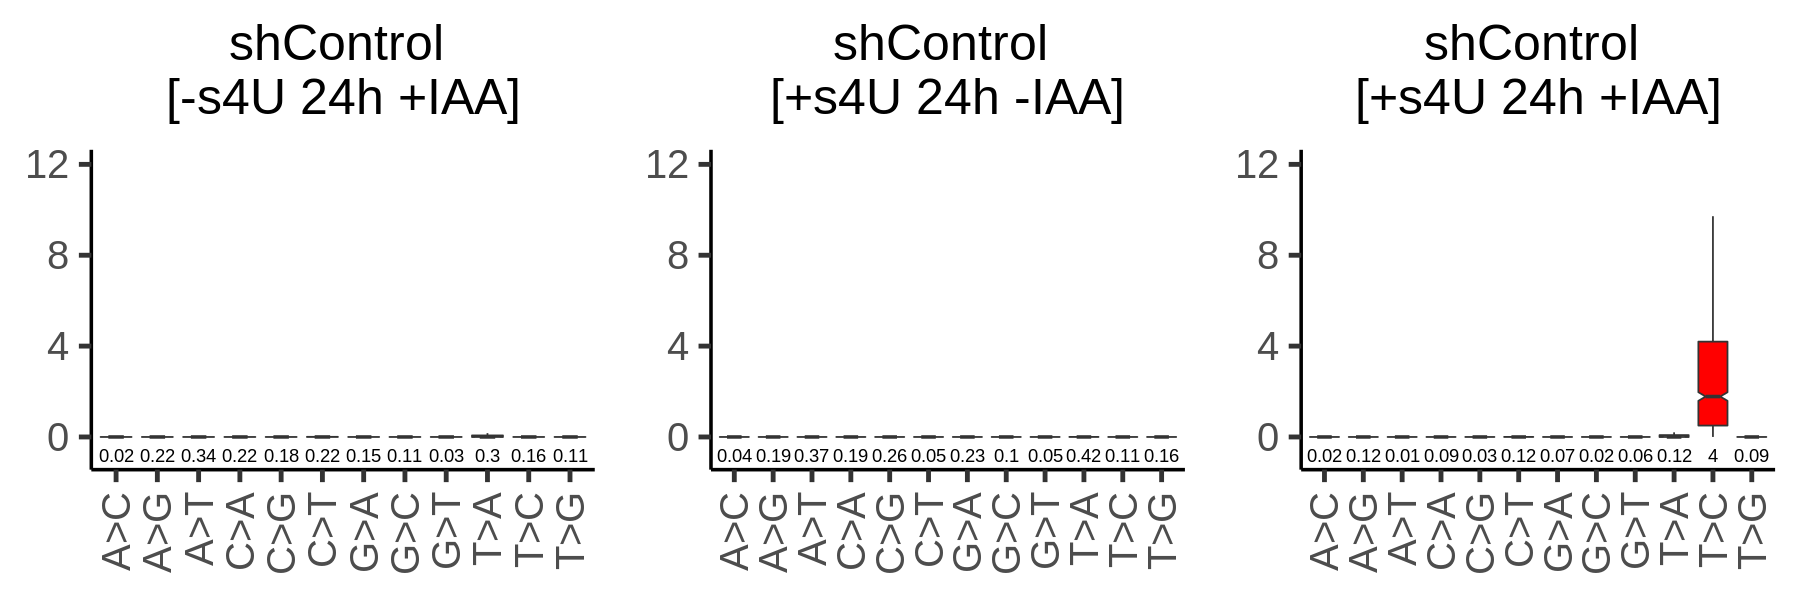

In [15]:

#a <- ggplot(muts.gfp.noS4U.noIAA, aes(x=mutCode, y=rate.pct)) + 
#    theme_bw(base_size = 30) +
#    ggtitle("shControl \n[-s4U 24h -IAA]") +
#    theme(plot.title = element_text(hjust = '0.5', size=30)) +
#    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
#              panel.background = element_blank(), panel.border = element_blank()) +
#    theme(axis.line = element_line(colour = "black", size = 1), 
#              axis.title.x = element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
#    coord_cartesian(ylim = c(-0.8,12))+
#    ylab("Conversion rate [%]")+
#    geom_boxplot(notch=TRUE,outlier.shape=NA, fill=c(rep("white", times=10), "red", "white")) +
#    annotate("text", x=c(1:12), y=-0.8, label= texta) 

b <- ggplot(muts.gfp.noS4U, aes(x=mutCode, y=rate.pct)) + 
    theme_bw(base_size = 30) +
    ggtitle("shControl \n[-s4U 24h +IAA]") +
    theme(plot.title = element_text(hjust = '0.5', size=30)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 1), 
              axis.title.x = element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
             axis.title.y = element_blank()) +
    coord_cartesian(ylim = c(-0.8,12))+
    geom_boxplot(notch=TRUE,outlier.shape=NA, fill=c(rep("white", times=10), "red", "white")) +
    annotate("text", x=c(1:12), y=-0.8, label= textb) 

c <- ggplot(muts.gfp.noIAA, aes(x=mutCode, y=rate.pct)) + 
    theme_bw(base_size = 30) +
    ggtitle("shControl \n[+s4U 24h -IAA]") +
    theme(plot.title = element_text(hjust = '0.5', size=30)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 1), axis.title.y = element_blank(),
              axis.title.x =element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    coord_cartesian(ylim = c(-0.8,12))+
    geom_boxplot(notch=TRUE,outlier.shape=NA, fill=c(rep("white", times=10), "red", "white")) +
    annotate("text", x=c(1:12), y=-0.8, label= textc) 

d <- ggplot(muts.gfp.S4U, aes(x=mutCode, y=rate.pct)) + 
    theme_bw(base_size = 30) +
    ggtitle("shControl \n[+s4U 24h +IAA]") +
    theme(plot.title = element_text(hjust = '0.5', size=30)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 1), axis.title.y = element_blank(),
              axis.title.x = element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    coord_cartesian(ylim = c(-0.8,12))+
    geom_boxplot(notch=TRUE,outlier.shape=NA, fill=c(rep("white", times=10), "red", "white")) +
    annotate("text", x=c(1:12), y=-0.8, label= textd) 


options(repr.plot.width=15, repr.plot.height=5)
plot_grid(b,c,d, ncol = 3, rel_widths = c(1.05, 1,1))


# select for final list of 126 miRNAs!

In [17]:
m <- read.delim("126_final_miRNA_analyzed_inputReadsNorm.txt") # defined in timecourse_ppm.ipynb
miRs <- m$V1
miRs

[1] "miR-25-3p"   "let-7i-5p"   "let-7d-5p"   "miR-93-5p"   "miR-191-5p" 
  [6] "miR-17-5p"   "miR-224-5p"  "miR-21-5p"   "miR-29a-3p"  "let-7e-5p"  
 [11] "miR-423-5p"  "miR-130a-3p" "let-7g-5p"   "miR-98-5p"   "miR-31-5p"  
 [16] "miR-222-3p"  "miR-99b-5p"  "miR-342-3p"  "miR-23a-3p"  "miR-151a-3p"
 [21] "miR-27a-3p"  "let-7b-5p"   "miR-34a-5p"  "miR-30a-3p"  "miR-221-3p" 
 [26] "miR-23b-3p"  "miR-423-3p"  "miR-125a-5p" "miR-425-5p"  "miR-324-5p" 
 [31] "let-7f-5p"   "miR-151a-5p" "miR-424-5p"  "miR-92b-3p"  "miR-15b-5p" 
 [36] "miR-106b-3p" "miR-331-3p"  "miR-1307-3p" "miR-15b-3p"  "let-7a-5p"  
 [41] "miR-455-3p"  "miR-744-5p"  "miR-130b-3p" "miR-24-3p"   "miR-148b-3p"
 [46] "miR-27b-3p"  "miR-454-3p"  "miR-675-5p"  "miR-185-5p"  "miR-374b-5p"
 [51] "miR-21-3p"   "miR-17-3p"   "miR-532-3p"  "miR-140-3p"  "let-7c-5p"  
 [56] "miR-22-3p"   "let-7d-3p"   "miR-30b-5p"  "miR-19a-3p"  "miR-183-5p" 
 [61] "miR-675-3p"  "miR-629-5p"  "miR-326-5p"  "miR-28-5p"   "miR-149-5p" 
 [66] "miR-30e-3p"  "miR-532-5p"  "miR-18a-3p"  "miR-126-5p"  "miR-99a-5p" 
 [71] "miR-24-5p"   "miR-186-5p"  "miR-210-3p"  "miR-301a-3p" "miR-193b-5p"
 [76] "let-7i-3p"   "miR-29c-3p"  "miR-100-5p"  "miR-378a-5p" "miR-23a-5p" 
 [81] "miR-324-3p"  "miR-30a-5p"  "miR-424-3p"  "miR-877-5p"  "miR-99b-3p" 
 [86] "miR-330-5p"  "miR-193b-3p" "miR-98-3p"   "miR-130b-5p" "miR-1908-5p"
 [91] "miR-576-5p"  "miR-106b-5p" "miR-345-5p"  "miR-181b-5p" "miR-30c-3p" 
 [96] "miR-16-3p"   "miR-3200-3p" "miR-190a-5p" "miR-92a-5p"  "miR-31-3p"  
[101] "miR-196b-5p" "miR-425-3p"  "miR-196a-5p" "miR-92b-5p"  "miR-28-3p"  
[106] "miR-25-5p"   "miR-26b-5p"  "miR-193a-5p" "miR-1306-5p" "miR-140-5p" 
[111] "miR-296-5p"  "miR-146b-5p" "miR-18a-5p"  "miR-4521-5p" "miR-374a-5p"
[116] "miR-30b-3p"  "miR-99a-3p"  "miR-27b-5p"  "miR-378a-3p" "miR-22-5p"  
[121] "miR-374a-3p" "miR-1275-5p" "miR-582-5p"  "miR-27a-5p"  "miR-19b-3p" 
[126] "miR-629-3p"

In [18]:
length(unique(muts.gfp$arm.name))
muts.gfp <- muts.gfp[grepl(paste0(miRs, collapse = "|"),muts.gfp$arm.name),]
length(unique(muts.gfp$arm.name))

#length(unique(muts.11$arm.name))
#muts.11 <- muts.11[grepl(paste0(miRs, collapse = "|"),muts.11$arm.name),]
#length(unique(muts.11$arm.name))

[1] 210

[1] 126

In [19]:
muts.gfp.code <- 
    muts.gfp %>%
    filter(relPos <= 18) %>%
    left_join(BG.gfp) %>%
    replace_na(list(mutFract.BG = 0)) %>%
    mutate(mutFract.fin = ifelse(mutFract < mutFract.BG, 0, mutFract-mutFract.BG)) %>%
    mutate(rate.pct = mutFract.fin * 100) %>%
    select(timepoint, mutCode, rate.pct) %>%
    arrange(by=mutCode)

head(muts.gfp.code)


#muts.11.code <- 
#    muts.11 %>%
#    filter(relPos <= 18) %>%
#    left_join(BG.11) %>%
#    replace_na(list(mutFract.BG = 0)) %>%
#    mutate(mutFract.fin = ifelse(mutFract < mutFract.BG, 0, mutFract-mutFract.BG)) %>%
#    mutate(rate.pct = mutFract.fin * 100) %>%
#    select(timepoint, mutCode, rate.pct) %>%
#    arrange(by=mutCode)

#head(muts.11.code)


Joining, by = c("pos", "relPos", "flybase_id", "mir.type", "start.pos", "arm.name", "seed", "UCount", "strand", "X.", "mutCode")



,timepoint,mutCode,rate.pct
,<chr>,<chr>,<dbl>
1,mergeAll_shGFP_24h,A>C,0
2,mergeAll_shGFP_24h,A>C,0
3,mergeAll_shGFP_24h,A>C,0
4,mergeAll_shGFP_24h,A>C,0
5,mergeAll_shGFP_24h,A>C,0
6,mergeAll_shGFP_24h,A>C,0


In [20]:
#muts.gfp.noS4U.noIAA <- muts.gfp.code[grepl("mergeRepl_60_shGFP_24h_noS4U_noIAA",muts.gfp.code$timepoint),]
muts.gfp.noS4U <- muts.gfp.code[grepl("mergeAll_shGFP_24h_noS4U",muts.gfp.code$timepoint),]
muts.gfp.noIAA <- muts.gfp.code[grepl("mergeAll_shGFP_24h_noIAA",muts.gfp.code$timepoint),]
muts.gfp.S4U <- muts.gfp.code[grepl("mergeAll_shGFP_24h$",muts.gfp.code$timepoint),]


#muts.11.noS4U.noIAA <- muts.11.code[grepl("mergeRepl_72_sh11_24h_noS4U_noIAA",muts.11.code$timepoint),]
##muts.11.noS4U <- muts.11.code[grepl("mergeRepl_70_sh11_24h_noS4U",muts.11.code$timepoint),]
#muts.11.noIAA <- muts.11.code[grepl("mergeRepl_71_sh11_24h_noIAA",muts.11.code$timepoint),]
#muts.11.S4U <- muts.11.code[grepl("mergeRepl_69_sh11_24h",muts.11.code$timepoint),]


In [21]:
#muts.gfp.noS4U.noIAA <- 
#     muts.gfp.noS4U.noIAA %>%
#    group_by(mutCode) %>%
#     mutate(mean=mean(rate.pct))

#texta <- round(unique(muts.gfp.noS4U.noIAA$mean), digits=2)

muts.gfp.noS4U <- 
     muts.gfp.noS4U %>%
    group_by(mutCode) %>%
     mutate(mean=mean(rate.pct))
textb <- round(unique(muts.gfp.noS4U$mean), digits=2)

muts.gfp.noIAA <- 
     muts.gfp.noIAA %>%
    group_by(mutCode) %>%
     mutate(mean=mean(rate.pct))
textc <- round(unique(muts.gfp.noIAA$mean), digits=2)

muts.gfp.S4U <- 
     muts.gfp.S4U %>%
    group_by(mutCode) %>%
     mutate(mean=mean(rate.pct))
textd <- round(unique(muts.gfp.S4U$mean), digits=2)
#head(muts.gfp.S4U)





notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.

notch went outside hinges. Try setting notch=FALSE.



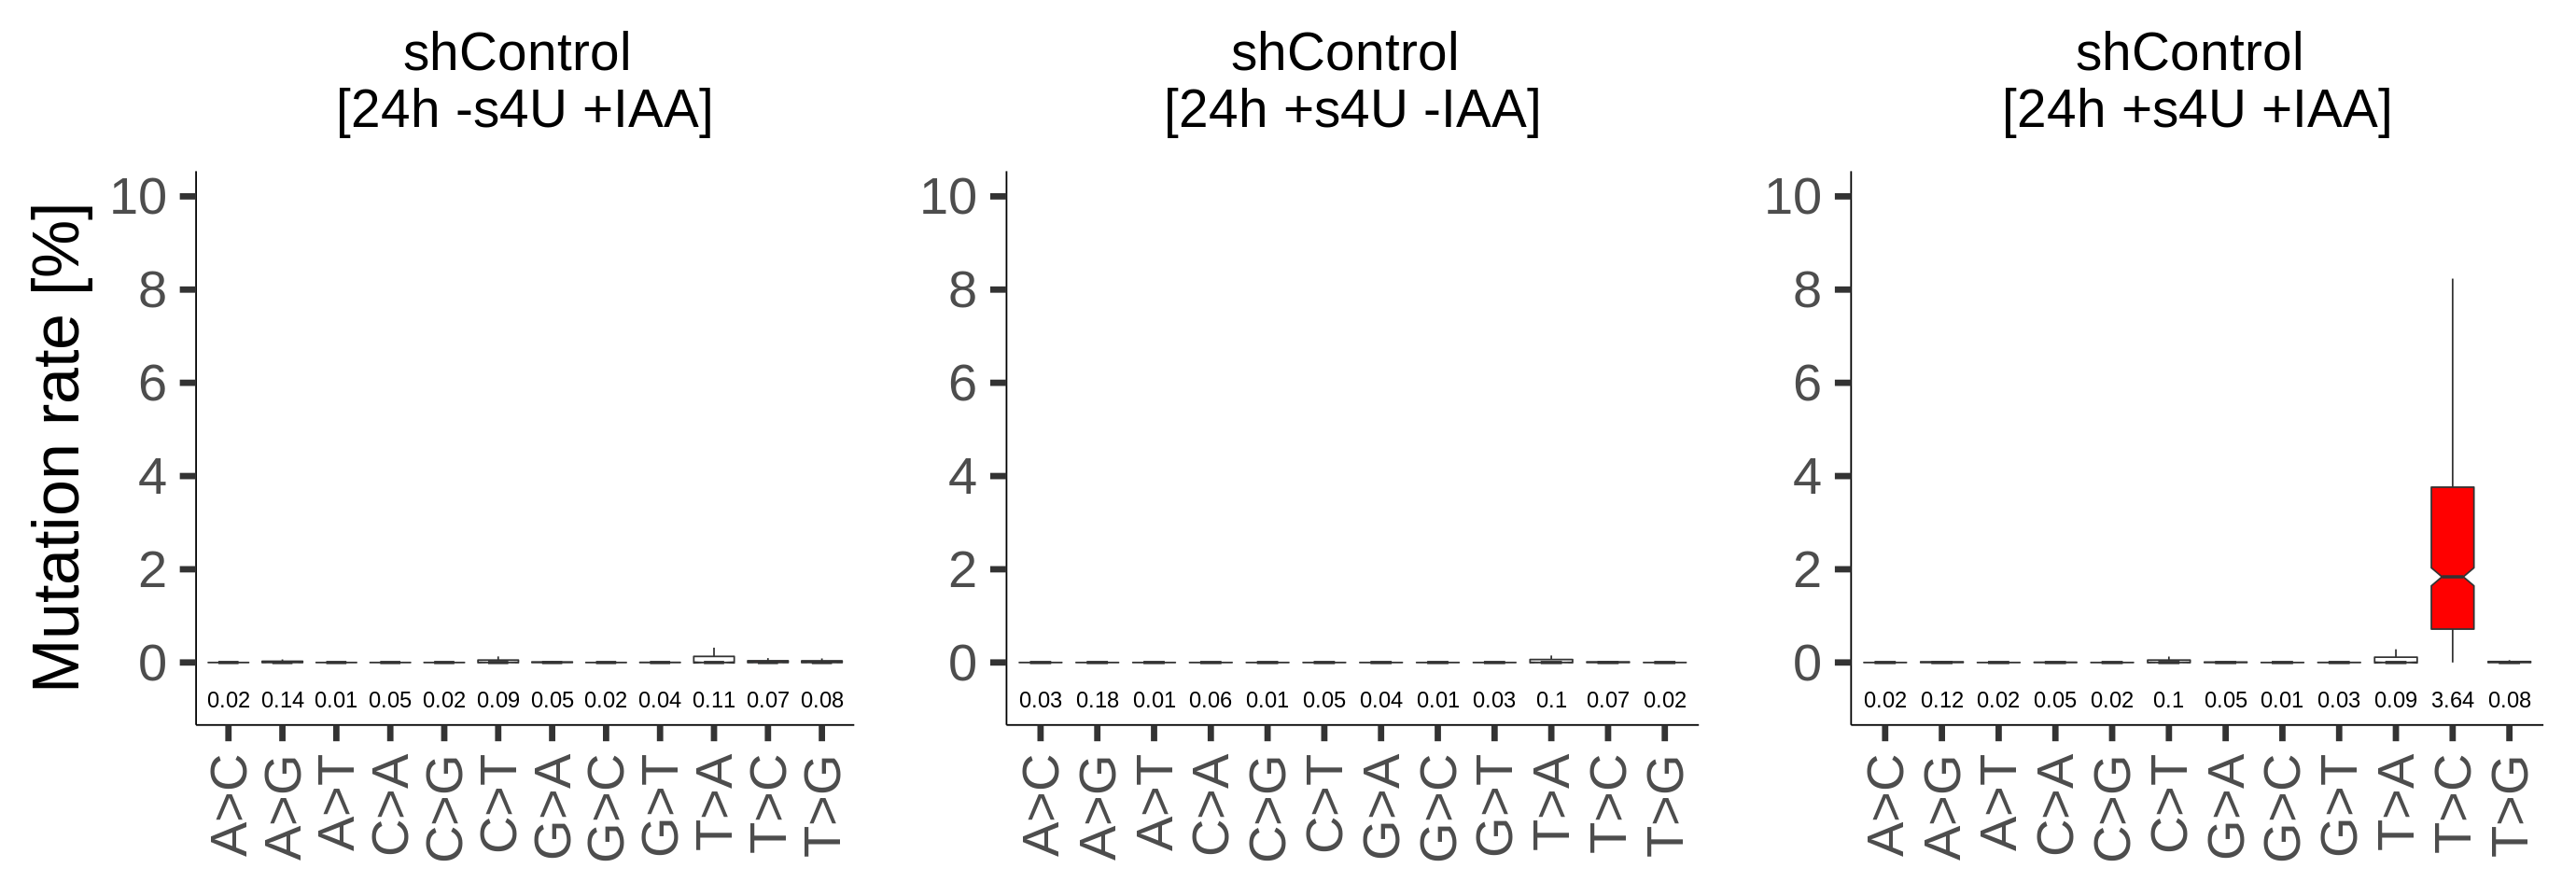

In [22]:

#a <- ggplot(muts.gfp.noS4U.noIAA, aes(x=mutCode, y=rate.pct)) + 
#    theme_bw(base_size = 30) +
#    ggtitle("shControl \n[-s4U 24h -IAA]") +
#    theme(plot.title = element_text(hjust = '0.5', size=30)) +
#    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
##              panel.background = element_blank(), panel.border = element_blank()) +
 ##   theme(axis.line = element_line(colour = "black", size = 1), 
#              axis.title.x = element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
#    coord_cartesian(ylim = c(-0.8,10))+
#    ylab("Conversion rate [%]")+
#    scale_y_continuous(breaks =c(0, 2, 4,6,8,10))+
#    geom_boxplot(notch=TRUE,outlier.shape=NA, fill=c(rep("white", times=10), "red", "white")) +
#    annotate("text", x=c(1:12), y=-0.8, label= texta) 

b <- ggplot(muts.gfp.noS4U, aes(x=mutCode, y=rate.pct)) + 
    theme_bw(base_size = 42) +
    ggtitle("shControl \n[24h -s4U +IAA]") +
    theme(plot.title = element_text(hjust = '0.5', size=34)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 0.5), 
              axis.title.x = element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ylab("Mutation rate [%]")+
    coord_cartesian(ylim = c(-0.8,10))+
    scale_y_continuous(breaks =c(0, 2, 4,6,8,10))+
    geom_boxplot(notch=TRUE,outlier.shape=NA, fill=c(rep("white", times=10), "red", "white")) +
    annotate("text", x=c(1:12), y=-0.8, label= textb, size=5) 

c <- ggplot(muts.gfp.noIAA, aes(x=mutCode, y=rate.pct)) + 
    theme_bw(base_size = 42) +
    ggtitle("shControl \n[24h +s4U -IAA]") +
    theme(plot.title = element_text(hjust = '0.5', size=34)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 0.5), axis.title.y = element_blank(),
              axis.title.x =element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    coord_cartesian(ylim = c(-0.8,10))+
    scale_y_continuous(breaks =c(0, 2, 4,6,8,10))+
    geom_boxplot(notch=TRUE,outlier.shape=NA, fill=c(rep("white", times=10), "red", "white")) +
    annotate("text", x=c(1:12), y=-0.8, label= textc, size=5) 

d <- ggplot(muts.gfp.S4U, aes(x=mutCode, y=rate.pct)) + 
    theme_bw(base_size = 42) +
    ggtitle("shControl \n[24h +s4U +IAA]") +
    theme(plot.title = element_text(hjust = '0.5', size=34)) +
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
              panel.background = element_blank(), panel.border = element_blank()) +
    theme(axis.line = element_line(colour = "black", size = 0.5), axis.title.y = element_blank(),
              axis.title.x = element_blank(), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    coord_cartesian(ylim = c(-0.8,10))+
    scale_y_continuous(breaks =c(0, 2, 4,6,8,10))+
    geom_boxplot(notch=TRUE,outlier.shape=NA, fill=c(rep("white", times=10), "red", "white")) +
    annotate("text", x=c(1:12), y=-0.8, label= textd, size=5) 


options(repr.plot.width=23, repr.plot.height=8)
plot_grid(b,c,d, ncol = 3, rel_widths = c(1.05, 1,1))

